In [5]:
%load_ext cython
%matplotlib notebook


import numpy as np
from ipywidgets import interact
from PIL import Image
from numpy.fft import rfft2, irfft2, fftshift
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import h5py
def autocorrelation(img):
    fft_final = rfft2(img)
    return fftshift(irfft2(fft_final * np.conj(fft_final)))
    
def radial_autocorrelation(img):
    ac = autocorrelation(img)
    shape = img.shape
    max_r = int(np.min(shape) / np.sqrt(2)) + 1
    hist = np.zeros(max_r + 1)
    counts = np.zeros(max_r + 1)
    for i in range(shape[0]):
        for j in range(shape[1]):
            r = int(np.sqrt((i - 0.5 * shape[0]) ** 2 + (j - 0.5 * shape[1])**2))
            hist[r] += ac[i, j]
            counts[r] += 1
            
    rhist = hist[counts > 0]/counts[counts > 0]
    rs = np.arange(0, max_r)
    return rs, rhist

def display_ising_sequence(images):
    def _show(frame=(0, len(images) - 1)):
        return display_spin_field(images[frame])
    return interact(_show)

def random_spin_field(N, M):
    return np.random.choice([-1, 1], size=(N, M))

def display_spin_field(field):
    return Image.fromarray(np.uint8((field + 1) * 0.5 * 255))  # 0 ... 255

def magentization(img):
    np.sum(img)


The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [6]:
%%cython

cimport cython

import numpy as np
cimport numpy as np

from libc.math cimport exp
from libc.stdlib cimport rand
cdef extern from "limits.h":
    int RAND_MAX


@cython.boundscheck(False)
@cython.wraparound(False)
def cy_ising_step(np.int64_t[:, :] field, float beta=0.4):
    cdef int N = field.shape[0]
    cdef int M = field.shape[1]
    cdef int n_offset, m_offset, n, m
    for n_offset in range(2):
        for m_offset in range(2):
            for n in range(n_offset, N, 2):
                for m in range(m_offset, M, 2):
                    _cy_ising_update(field, n, m, beta)
    return np.array(field)


@cython.boundscheck(False)
@cython.wraparound(False)
cdef _cy_ising_update(np.int64_t[:, :] field, int n, int m, float beta):
    cdef int total = 0
    cdef int N = field.shape[0]
    cdef int M = field.shape[1]
    cdef int i, j
    for i in range(n-1, n+2):
        for j in range(m-1, m+2):
            if i == n and j == m:
                continue
            total += field[i % N, j % M]
    cdef float dE = 2 * field[n, m] * total
    if dE <= 0:
        field[n, m] *= -1
    elif exp(-dE * beta) * RAND_MAX > rand():
        field[n, m] *= -1


* Introduce Ising model in 1D
* Explain Monte Carlo, Explain Correlation Function
* Explain Magentization, show magentization as a function of temperature
* Introduce 2D Model
* Prompts about simulation results at 3 temperatures
* What do you expect the autocorrelation to look like in these cases? Plot them.
* Simulate at beta 0.1 to 0.3 - ten 

In [9]:
step = random_spin_field(200, 200)

betas = [0.1, 0.13, 0.15, 0.17, 0.18, 0.19, 0.195, 0.20, 0.21, 0.23, 0.24, 0.25, 0.26, 0.3]
beta = betas[-1]

trial_number = 0
for beta in betas:
    for trial in range(10):

        step = random_spin_field(200, 200)
        trial_number += 1

        if beta > 0.2:

            for i in range(50):
                print('Prequench Trial: {}, Beta: {}, Step: {}'.format(trial, beta, i))
                for j in range(20):
                    step = cy_ising_step(step.copy(), beta=0.19)

                display.clear_output()

            anneal = np.concatenate((
                np.linspace(0.19, beta, 1000),
                np.linspace(beta, 0.19, 1000),
                np.linspace(0.19, beta, 5000),
            ))
            print('Annealing')
            for beta_anneal in anneal:
                step = cy_ising_step(step.copy(), beta=beta_anneal)

        for i in range(100):

            print('Trial: {}, Beta: {}, Step: {}'.format(trial, beta, i))
            for j in range(500):
                step = cy_ising_step(step.copy(), beta=beta)

            display.clear_output()


        with h5py.File('run_{}.hdf5'.format(trial_number), 'w') as outf:
            outf['image'] = step
            outf.attrs['beta'] = beta
            print(outf)

<HDF5 file "run_140.hdf5" (mode r+)>


In [110]:
import glob

In [112]:
glob.glob('*.hdf5')

['trial_7.hdf5',
 'trial_8.hdf5',
 'trial_10.hdf5',
 'trial_6.hdf5',
 'trial_3.hdf5',
 'trial_2.hdf5',
 'trial_5.hdf5',
 'trial_1.hdf5',
 'trial_4.hdf5',
 'test2.hdf5',
 'test1.hdf5',
 'test.hdf5',
 'trial_9.hdf5']

In [34]:
final = images[-1]

In [35]:
rs, radial_ac = radial_autocorrelation(final)

<IPython.core.display.Javascript object>


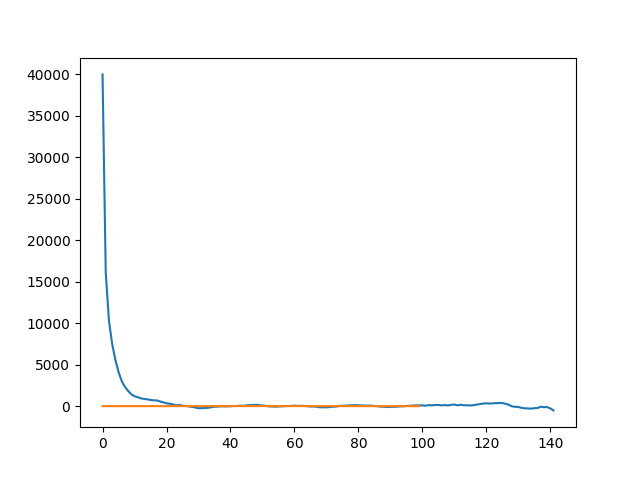

In [52]:
plt.plot(rs, radial_ac)

In [40]:
!pip install h5py

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 2.9 MB 828 kB/s eta 0:00:01


In [41]:
import h5py

<HDF5 file "test2.hdf5" (mode r+)>


In [174]:
with h5py.File('trial_135.hdf5', 'r') as inf:
    img = np.array(inf['image'])
    beta = float(inf.attrs['beta'])

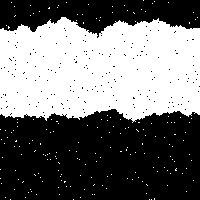

In [175]:
display_spin_field(img)

In [176]:
beta

0.3